# Orientation optimization
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/planar/orientation.ipynb)

In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from torchfem.rotations import planar_rotation
from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import OrthotropicElasticityPlaneStress

torch.set_default_dtype(torch.float64)

In [2]:
mat = OrthotropicElasticityPlaneStress(
    E_1=100000.0, E_2=10000.0, nu_12=0.1, G_12=5000.0
)

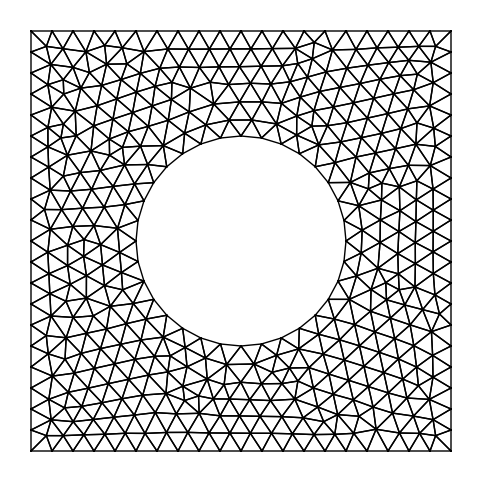

In [3]:
# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), mat)
plate.plot()

## Boundary conditions

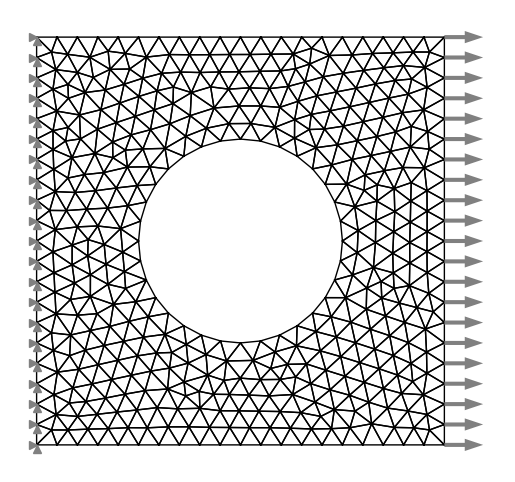

In [4]:
plate.constraints[plate.nodes[:, 0] == 0.0] = True
plate.forces[plate.nodes[:, 0] >= 0.199] = 10.0
plate.forces[:, 1] = 0.0
plate.plot()

## Solve initial configuration

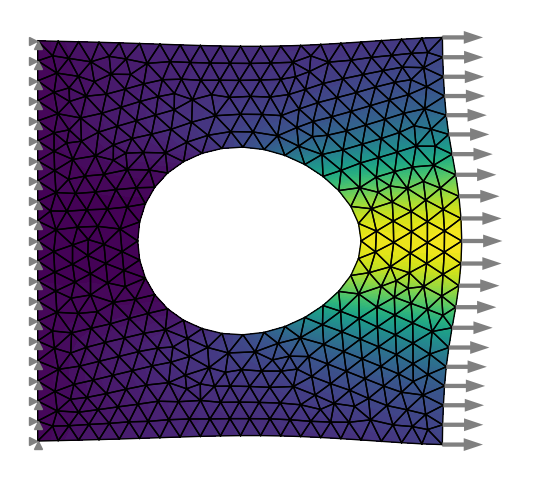

In [5]:
u, f, sigma, epsilon, state = plate.solve()
plate.plot(u=u, node_property=u[:, 0])

# Optimization

## Target function is the strain energy

In [6]:
def target_function(phi):
    # Recompute stiffness due to changed orientations
    R = planar_rotation(phi)
    plate.material = mat.vectorize(plate.n_elem).rotate(R)
    # Solve
    u, f, _, _, _ = plate.solve()
    # Return compliance
    return torch.inner(u.ravel(), f.ravel())

## The optimization

In [7]:
phi = torch.zeros((len(plate.elements)), requires_grad=True)

optimizer = torch.optim.Adam([phi], lr=0.1)

energies = []

for _ in tqdm(range(100)):
    optimizer.zero_grad()
    objective = target_function(phi)
    energies.append(objective.detach().item())
    objective.backward()
    optimizer.step()

100%|██████████| 100/100 [00:02<00:00, 37.09it/s]


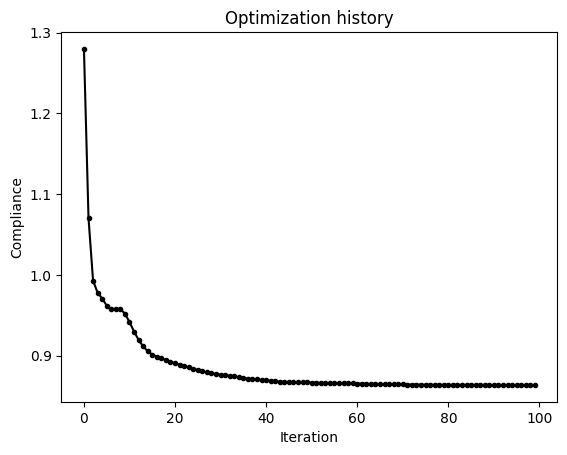

In [8]:
plt.plot(energies, ".-k")
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

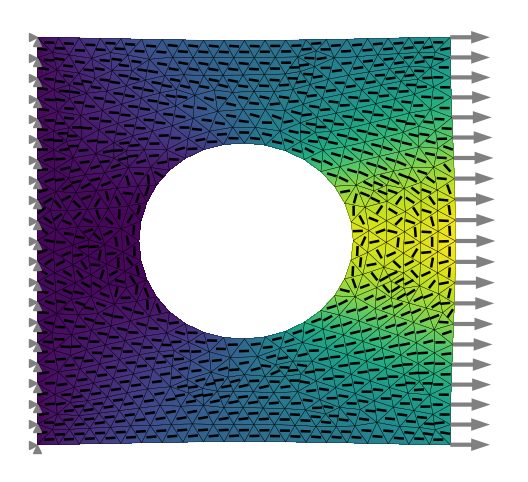

In [9]:
# Compute optimized displacements
u, f, _, _, _ = plate.solve()

# Plot orientations
plate.plot(u=u, node_property=u[:, 0], linewidth=0.2, orientation=phi)